In [1]:
#pip install umap-learn
#pip install scikit-learn
#pip install pynndescent==0.5.8 
#pip install matplotlib
#pip install ipympl
# jupyter labextension install jupyter-matplotlib

%matplotlib ipympl
import matplotlib.pyplot as plt

import umap
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from scipy.ndimage import uniform_filter

In [2]:
import seaborn as sns
palette = sns.color_palette("colorblind")


In [3]:
file_names = ["R1_9AA", "R2_1_9AA","R2_9AA", "R3_9AA", "R4_9AA", "R5_9AA", "R6_1_9AA", "R7_1_9AA", "R7_9AA", "R8_9AA"]

In [9]:
# Load flattened data
maldi_data = [np.load(f"cm_data/{name}.npz")['arr_0'] for name in file_names]

In [10]:
def preprocess(md, size=3):
    # Add total ioncount
    TIC = md.sum(axis=2)
    max_TIC = np.max(TIC)
    norm_TIC = TIC #/ max_TIC
    
    # Normalize ions
    md = md #/ (TIC + (md.sum(axis=2) == 0))[:,:, np.newaxis]  
    md_TIC = np.dstack([md,norm_TIC])
    
    proccesed_md = uniform_filter(md_TIC, size=size)
    return proccesed_md

In [11]:
# moving mean 
maldi_data_process = [preprocess(md) for md in maldi_data]

In [12]:
def add_spatial_info(md,i=0):
    nx,ny = md.shape[:2]
    #XX,YY = np.meshgrid(np.linspace(0,1,ny),np.linspace(0,1,nx))
    XX,YY = np.meshgrid(range(ny),range(nx))
    II = YY*0 + i
    md_spatial = np.dstack([md,XX,YY,II])
    return md_spatial

maldi_data_process_spatial = [add_spatial_info(md,i=i) for i,md in enumerate(maldi_data_process)]

In [13]:
maldi_data_process_spatial[2][:,:,:-1][:,:,-1]

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  1.,   1.,   1., ...,   1.,   1.,   1.],
       [  2.,   2.,   2., ...,   2.,   2.,   2.],
       ...,
       [210., 210., 210., ..., 210., 210., 210.],
       [211., 211., 211., ..., 211., 211., 211.],
       [212., 212., 212., ..., 212., 212., 212.]])

In [14]:
# Dont account fo sample ID 
maldi_data_flattened = [md[:,:,:-1].reshape(-1, md[:,:,:-1].shape[-1]) for md in maldi_data_process_spatial]

In [15]:
maldi_data_flattened_concat = np.concatenate(maldi_data_flattened)

In [16]:
# Normalize the total ioncount accros all images

In [17]:
#scaled_maldi_data = maldi_data_flattened_concat #StandardScaler().fit_transform(maldi_data_flattened_concat)
scaled_maldi_data = StandardScaler().fit_transform(maldi_data_flattened_concat)


In [18]:
flattened_sample_id =np.concatenate([md[:,:,-1:].reshape(-1, md[:,:,-1:].shape[-1]) for md in maldi_data_process_spatial])

In [19]:
# Sparse u
reducer = umap.UMAP(
    n_neighbors=50,
    metric="cosine",
    min_dist=0.0,
)

In [20]:
embedding = reducer.fit_transform(scaled_maldi_data)

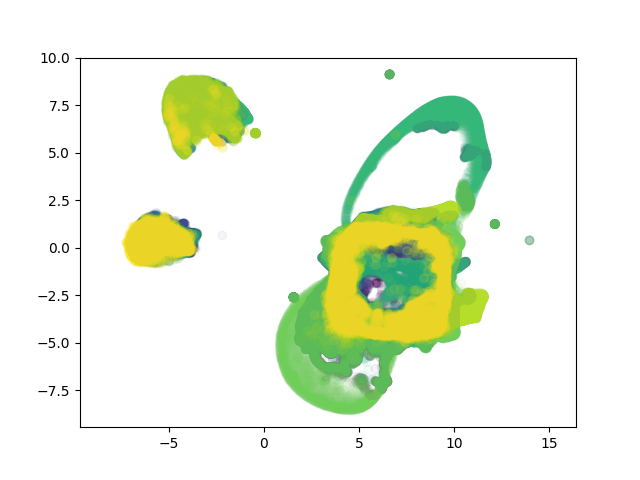

In [21]:
fig = plt.figure()
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    alpha=0.05,
    c=flattened_sample_id,
)
plt.gca().set_aspect('equal', 'datalim')
#plt.xlim([0,10])
plt.show()

In [22]:
def get_cluster_square(embedding, x=[0,10], y=[-4,4]):
    x_filter = (x[0] < embedding[:,0]) * (embedding[:,0] < x[1])
    y_filter = (y[0] < embedding[:,1]) * (embedding[:,1] < y[1])
    return x_filter*y_filter

def get_cluster_round(embedding, center=[0,10], r=0.5):
    dx = embedding[:,0] - center[0]
    dy = embedding[:,1] - center[1]
    return dx**2 + dy**2 <= r**2
    
def get_embedding_images(embeded_quant, maldi_data):
    ix_min = 0
    images = []
    for md in maldi_data:
        ix_max = ix_min + md.shape[0] * md.shape[1]
        print(ix_min,ix_max)
        image = embeded_quant[ix_min:ix_max].reshape(md.shape[:2])
        images.append(image)
        ix_min += md.shape[0] * md.shape[1]

    return images 
    

In [35]:
tissue_ix = embedding[:, 0] < 0 

In [36]:
from sklearn.cluster import HDBSCAN

hdb = HDBSCAN(min_cluster_size=50)
hdb.fit(embedding[tissue_ix])

HDBSCAN(min_cluster_size=50)

In [37]:
len(hdb.labels_) , len(tissue_ix)

(236761, 506365)

In [45]:
palette_w_black = [[(0.0,0.0,0.0),] + palette ]

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

C:\Users\dw6835\AppData\Local\Temp\ipykernel_13776\1002488854.py:2: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(


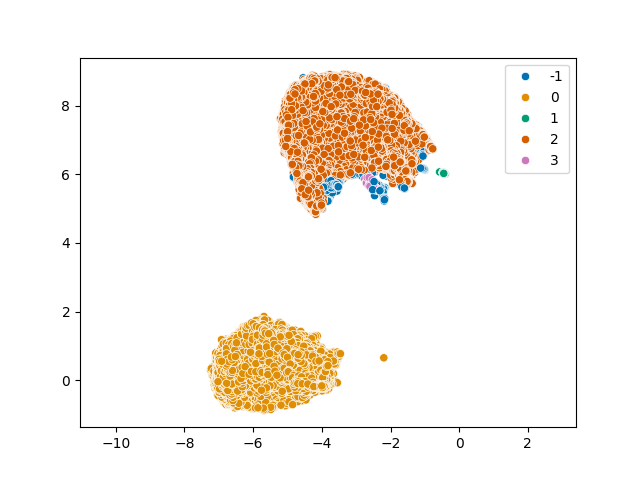

In [82]:
fig = plt.figure()
sns.scatterplot(
    x=embedding[tissue_ix, 0],
    y=embedding[tissue_ix, 1],
    hue=hdb.labels_, 
    palette=palette,
    alpha=1.0)
plt.gca().set_aspect('equal', 'datalim')
#plt.xlim([0,10])
#plt.colorbar()
plt.show()

In [52]:
cluster_image  = embedding[:, 1] * 0.0 - 1.0
cluster_image[tissue_ix] = hdb.labels_

images = get_embedding_images(cluster_image,maldi_data)
images[0]

0 21756
21756 53397
53397 107925
107925 152860
152860 228500
228500 260700
260700 298327
298327 351463
351463 452399
452399 506365


array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]], dtype=float32)

In [61]:
# Find clusters 
set(hdb.labels_)

{-1, 0, 1, 2, 3}

In [118]:
maldi_data_flattened_concat.shape

(506365, 103)

In [ ]:
maldi_data_flattened_concat[tissue_ix][hdb.labels_ >= 1][]

In [92]:
tissue_edl_cluster = maldi_data_flattened_concat[tissue_ix][hdb.labels_ == 0]
tissue_sol_cluster = maldi_data_flattened_concat[tissue_ix][hdb.labels_ >= 1]

In [107]:
# Load peak list 
peaks = np.load(f"cm_data/peaks_list.npz")
mu_diff = (tissue_edl_cluster.mean(axis=0) - tissue_sol_cluster.mean(axis=0) )[:len(peaks)]


Text(0, 0.5, 'count')

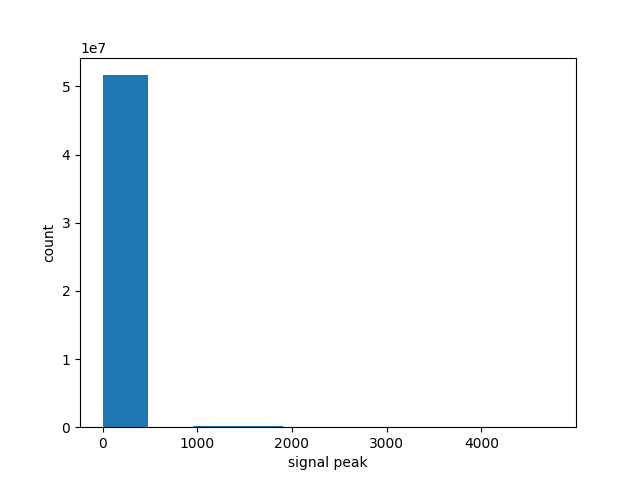

In [120]:
f = plt.figure()
#plt.hist(maldi_data_flattened_concat[tissue_ix][hdb.labels_ == 0][:,-3], alpha =0.5)
plt.hist(maldi_data_flattened_concat.flatten(),)
plt.xlabel('signal peak')
plt.ylabel('count')

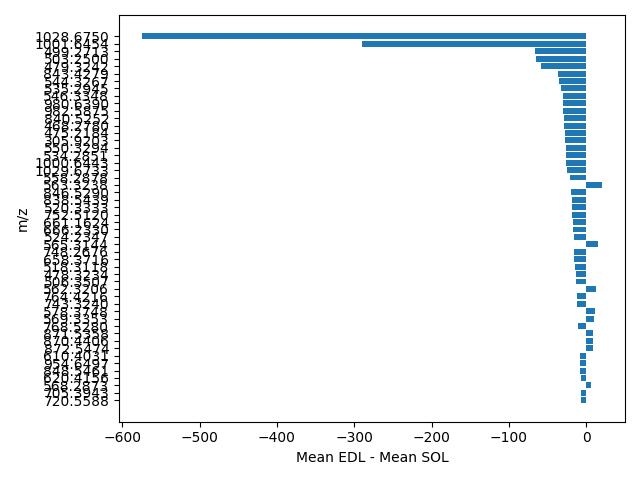

In [114]:
plt.figure()
mu_diff_sorted, peaks_sorted = zip( *sorted(zip(mu_diff,peaks), key=lambda pair: abs(pair[0]),reverse=False))

peaks_sorted_formated = [f"{p:.4f}" for p in peaks_sorted]
plt.barh(peaks_sorted_formated[-50:], mu_diff_sorted[-50:])
#plt.errorbar(peaks_sorted_formated[-10:], mu_diff_sorted[-10:]) 
plt.xlabel("Mean EDL - Mean SOL")
plt.ylabel("m/z")

plt.tight_layout()


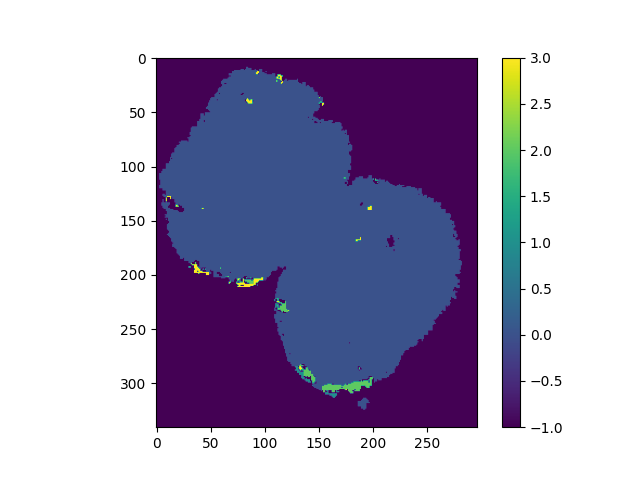

In [149]:
plt.figure()
plt.pcolor(images[3], )
plt.colorbar()

[-1.5 -0.5  0.5  1.5  2.5  3.5]


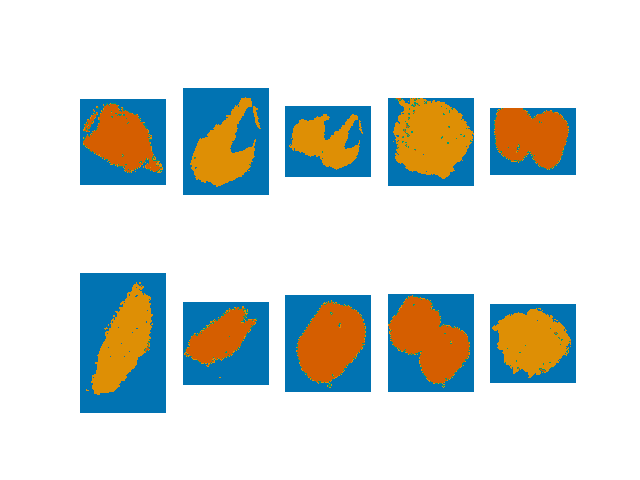

In [98]:
from matplotlib.colors import ListedColormap
import matplotlib

classes = set(hdb.labels_)

fig, axs = plt.subplots(2,5)

# Let's also design our color mapping: 1s should be plotted in blue, 2s in red, etc...
col_dict = {-1: palette[0],
            0: palette[1],
            1: palette[2],
            2: palette[3],
            3: palette[3],
           }

# We create a colormar from our list of colors
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

# Let's also define the description of each category : 1 (blue) is Sea; 2 (red) is burnt, etc... Order should be respected here ! Or using another dict maybe could help.
labels = classes
len_lab = len(labels)

# prepare normalizer
# Prepare bins for the normalizer
norm_bins = np.sort([*col_dict.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
print(norm_bins)
# Make normalizer and formatter
norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

for image, ax in zip(images,axs.reshape(-1)): 
    ax.imshow(image,cmap=cm, norm=norm)
    ax.spines.left.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.bottom.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    


In [63]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(scaled_maldi_data)

PCA(n_components=10)

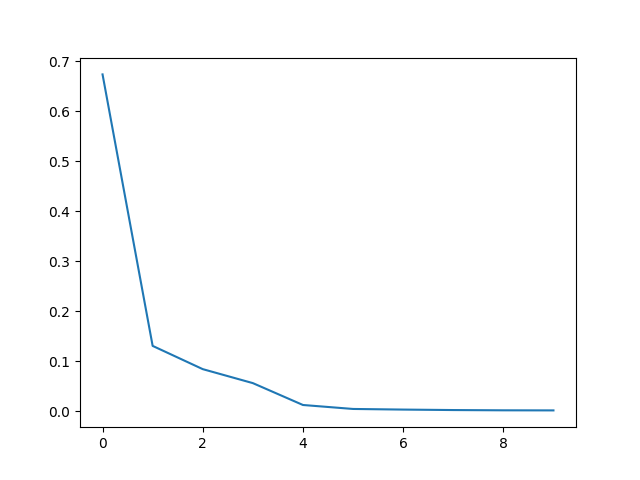

In [67]:
f = plt.figure()
plt.plot(pca.explained_variance_ratio_)

In [69]:
X = pca.transform(scaled_maldi_data)

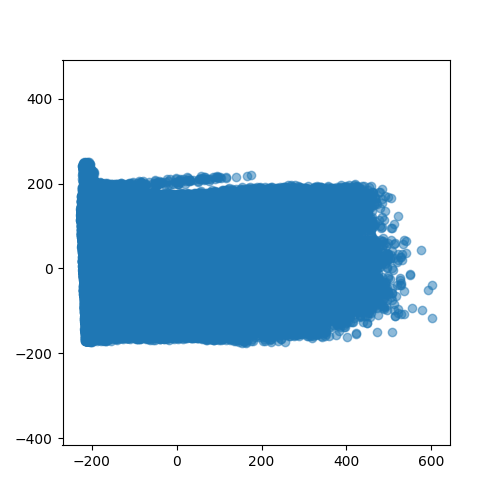

In [70]:
f = plt.figure(figsize=(5,5))
plt.scatter(
    X[:,0], X[:,1],alpha=0.5)
plt.gca().set_aspect('equal', 'datalim')
